In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import RandomOverSampler
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    log_loss,
    confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    precision_score,
    recall_score
)
import time
import lime
import lime.lime_tabular
import joblib
import shap
import eli5
import multiprocessing
import collections
multiprocessing.set_start_method("spawn", force=True)
from scipy.stats import chi2_contingency

np.random.seed(0)

In [2]:
df = pd.read_csv("Dataset_2_DATA.csv", encoding='cp1251')[lambda df: df['DAGSOORT'] == 1]
df_d = pd.read_csv("Dataset_2_DESCRIPTION.csv", encoding='cp1251')

df

,HHID,PERSID,VPLID,RitID,HH_VALID,P_VALID,KHVM,WEGGEWEEST,VERTREKP,AANTVPL,...,HHAUTO_N,HHAUTO,HHBESTEL,HHHYBRID,HHMOTOR,HHBROM,HHSNOR,HHFIETS,HHVOUWFIETS,HHEBIKE
0,30055622,3005562201,13957101,1395710101,2,3,2,1,2,2,...,3,1,0,0,1,0,0,1,0,1
1,30055622,3005562201,13957102,1395710201,2,3,2,1,2,2,...,3,1,0,0,1,0,0,1,0,1
2,30055622,3005562201,13957201,1395720101,2,3,1,1,2,4,...,3,1,0,0,1,0,0,1,0,1
3,30055622,3005562201,13957202,1395720201,2,3,1,1,2,4,...,3,1,0,0,1,0,0,1,0,1
7,30356310,3035631001,17204101,1720410101,2,3,8,1,2,1,...,2,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7304,30862294,3086229401,19042102,1904210201,2,3,1,1,2,5,...,1,1,0,0,0,0,0,1,0,0
7306,30862294,3086229401,19042103,1904210301,2,3,7,1,2,5,...,1,1,0,0,0,0,0,1,0,0
7307,30862294,3086229401,19042104,1904210401,2,3,7,1,2,5,...,1,1,0,0,0,0,0,1,0,0
7308,30862294,3086229401,19042201,1904220101,2,3,1,1,2,3,...,1,1,0,0,0,0,0,1,0,0


## Подготовка данных

### 1. Обработка пропущенных значений 

In [3]:
# Проверяем датафрейм на содержание NaN-значений
has_any_missing = df.isna().any().any()
print("Есть ли NaN в датафрейме?", has_any_missing)

# Может показаться, что пропусков нет, но если проверить столбцы на соотвествие типу object можно понять,
# что два столбца потенциально могут содержать "нетипичные" пропуски.
print(df.dtypes[df.dtypes != 'int64'])

# Проверим уникальные значения столбцов KREISDUUR и PARKEERKOSTEN
for col in df.select_dtypes(include=['object']).columns:
    print(f"Уникальные значения в {col}:")
    print(df[col].unique())

# Бинго! Пропуски в наборе данных обозначаются одним пробелом(' ')

Есть ли NaN в датафрейме? False
KREISDUUR        object
PARKEERKOSTEN    object
dtype: object
Уникальные значения в KREISDUUR:
['11' '8' '7' '5' '4' '3' '10' '6' '2' '9' ' ' '1']
Уникальные значения в PARKEERKOSTEN:
['0' '9' '3' '11' ' ' '13' '5' '4' '14' '12' '16' '10' '7' '2' '6' '1' '8']


In [4]:
# Првоеряем сколько строк с пустыми значениями у нас есть
print(len(df[df['PARKEERKOSTEN'] == ' ']) + len(df[df['KREISDUUR'] == ' ']))
# Проверяем как эти пустые значения расперделены по классам
print(df[df['PARKEERKOSTEN'] == ' ']['KHVM'].value_counts())
print(df[df['KREISDUUR'] == ' ']['KHVM'].value_counts())

84
KHVM
1    13
2     3
8     1
4     1
Name: count, dtype: int64
KHVM
6    20
1    18
4    16
8     4
3     3
2     2
7     2
5     1
Name: count, dtype: int64


In [5]:
# Распределение не плохое, удаляем записи с пропусками

df = df.drop(list(df[df['PARKEERKOSTEN'] == ' '].index) + list(df[df['KREISDUUR'] == ' '].index))

### 2. Удаление дубликатов

In [6]:
df = df.drop_duplicates()
display(df) # Как можно заметить, количество строк не изменилось
print(len(df))

,HHID,PERSID,VPLID,RitID,HH_VALID,P_VALID,KHVM,WEGGEWEEST,VERTREKP,AANTVPL,...,HHAUTO_N,HHAUTO,HHBESTEL,HHHYBRID,HHMOTOR,HHBROM,HHSNOR,HHFIETS,HHVOUWFIETS,HHEBIKE
0,30055622,3005562201,13957101,1395710101,2,3,2,1,2,2,...,3,1,0,0,1,0,0,1,0,1
1,30055622,3005562201,13957102,1395710201,2,3,2,1,2,2,...,3,1,0,0,1,0,0,1,0,1
2,30055622,3005562201,13957201,1395720101,2,3,1,1,2,4,...,3,1,0,0,1,0,0,1,0,1
3,30055622,3005562201,13957202,1395720201,2,3,1,1,2,4,...,3,1,0,0,1,0,0,1,0,1
7,30356310,3035631001,17204101,1720410101,2,3,8,1,2,1,...,2,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7304,30862294,3086229401,19042102,1904210201,2,3,1,1,2,5,...,1,1,0,0,0,0,0,1,0,0
7306,30862294,3086229401,19042103,1904210301,2,3,7,1,2,5,...,1,1,0,0,0,0,0,1,0,0
7307,30862294,3086229401,19042104,1904210401,2,3,7,1,2,5,...,1,1,0,0,0,0,0,1,0,0
7308,30862294,3086229401,19042201,1904220101,2,3,1,1,2,3,...,1,1,0,0,0,0,0,1,0,0


5616


### График 1 (Распределение классов целевой переменной (KHVM))

/var/folders/6g/dz7v7l1x2_56ltfk7109p55m0000gn/T/ipykernel_41440/3454307680.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='KHVM', data=df, order=class_order, palette='viridis')


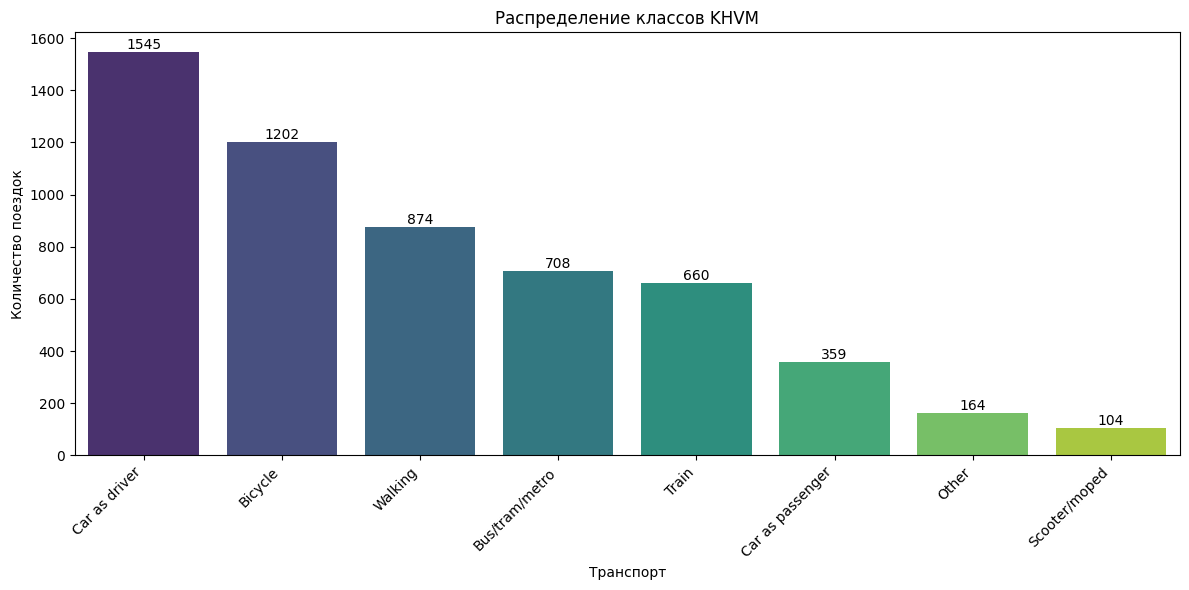

In [7]:
labels = {
    1: 'Car as driver',
    2: 'Car as passenger',
    3: 'Train',
    4: 'Bus/tram/metro',
    5: 'Scooter/moped',
    6: 'Bicycle',
    7: 'Walking',
    8: 'Other'
}

class_counts = df['KHVM'].value_counts().sort_values(ascending=False)
class_order = class_counts.index.tolist()

plt.figure(figsize=(12, 6))
ax = sns.countplot(x='KHVM', data=df, order=class_order, palette='viridis')
plt.title('Распределение классов KHVM')
plt.xlabel('Транспорт')
plt.ylabel('Количество поездок')

plt.xticks(
    ticks=range(len(class_order)),
    labels=[labels[i] for i in class_order],
    rotation=45,
    ha='right'
)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height(), int(p.get_height()), 
            ha='center', va='bottom')

plt.tight_layout()
plt.show()

### График 2 (Основные характеристики поездок)

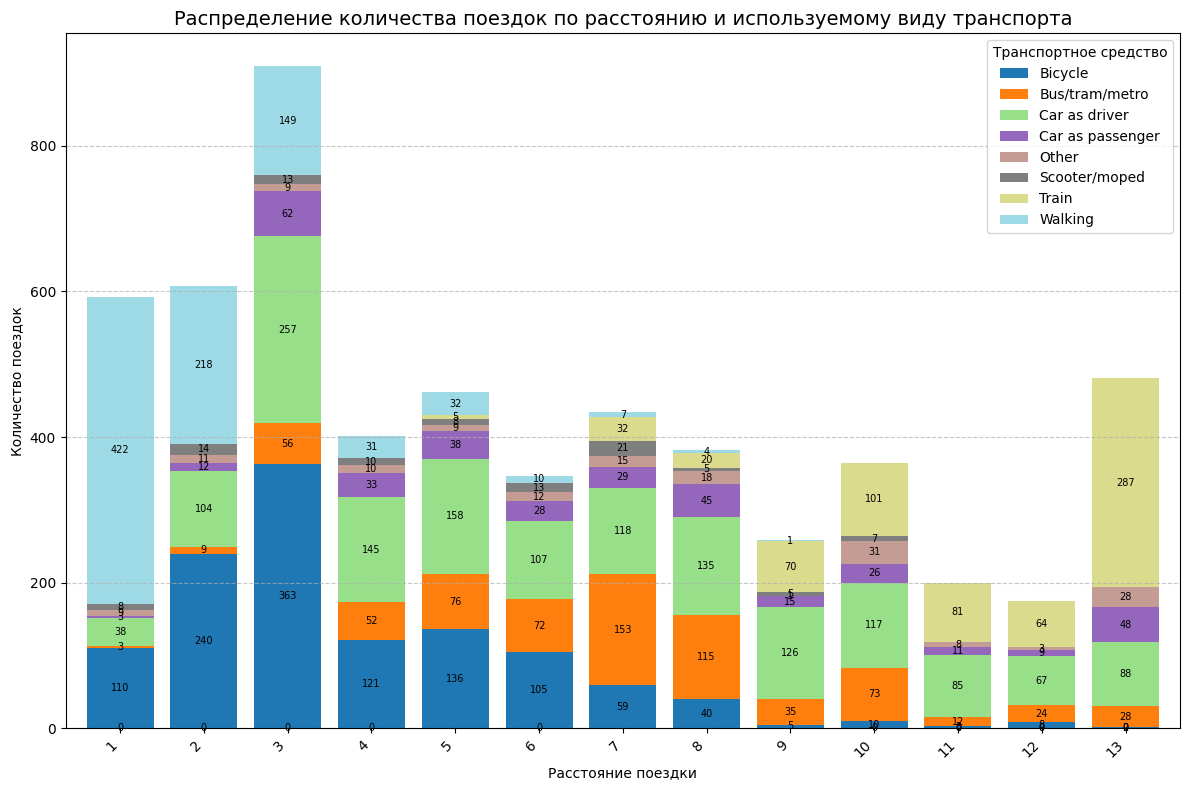

In [8]:
df1 = df.groupby(['KAFSTV', 'KHVM'], observed=False).size().reset_index().rename(
    columns={'KAFSTV': 'Расстояние поездки', 0: 'Количество поездок', 'KHVM': 'Транспортное средство'}
)

df1['Транспортное средство'] = df1['Транспортное средство'].map(labels)

pivot_df = df1.pivot(
    index='Расстояние поездки',
    columns='Транспортное средство',
    values='Количество поездок'
).fillna(0)

ax = pivot_df.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    width=0.8,
    colormap="tab20",
    legend=True
)

plt.title('Распределение количества поездок по расстоянию и используемому виду транспорта', fontsize=14)
plt.xlabel('Расстояние поездки')
plt.ylabel('Количество поездок')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='center', fontsize=7, color="black")

ax.set_xticklabels(list(pivot_df.index), rotation=45, ha='right')

plt.tight_layout()
plt.show()

### 3. Создание новых признаков и приведение типов данных

In [9]:
# Создание новых признаков
df['province_route'] = df['VERTPROV'].astype(str) + '_' + df['AANKPROV'].astype(str)

display(df[['VERTPROV', 'AANKPROV', 'province_route']])

,VERTPROV,AANKPROV,province_route
0,0,0,0_0
1,0,0,0_0
2,0,0,0_0
3,0,0,0_0
7,0,0,0_0
...,...,...,...
7304,27,20,27_20
7306,20,20,20_20
7307,20,20,20_20
7308,22,20,22_20


In [10]:
# Формируем списки по типам переменных

var_types = df_d[['Variable', 'Measurement_level']]
var_types = var_types.drop_duplicates()
grouped = var_types.groupby('Measurement_level')['Variable'].apply(list)

nominal_vars = grouped.get('Nominal', []) + ['province_route']
ordinal_vars = grouped.get('Ordinal', [])

print("Nominal:", nominal_vars)
print("Ordinal:", ordinal_vars)

Nominal: ['PERSOON', 'HH_VALID', 'IMPHHDATA', 'P_VALID', 'WEGGEWEEST', 'VERTREKP', 'AANTVPL', 'VPLDAGNR', 'VERPL', 'VERPLNR', 'TOER', 'TOER_TYPE', 'AANTRIT', 'DOEL', 'MOTIEF', 'KMOTIEF', 'VERTPROV', 'AANKPROV', 'HVM', 'KHVM', 'ROLAUTO', 'RIT', 'RITNR', 'KRVM', 'Bestuurder', 'BTYPEVERPL', 'BTYPEWERK', 'BHVM', 'KBHVM', 'BRVM', 'KBRVM', 'CORRECTIE_VVM', 'MARKERING_VVM', 'CORRECTIE_AFSTAND', 'CORRECTIE_REISTIJD', 'CORRECTIE_VERTREKDATUM', 'MARKERING_REISTIJD1', 'MARKERING_REISTIJD2', 'MARKERING_AFSTAND', 'MARKERING_OVERIG', 'DAGSOORT', 'WAVE4', 'STED_GM', 'PROV', 'COROP', 'HHSAM', 'HHAUTO_N', 'HHAUTO', 'HHBESTEL', 'HHHYBRID', 'HHMOTOR', 'HHBROM', 'HHSNOR', 'HHFIETS', 'HHVOUWFIETS', 'HHEBIKE', 'HHPEDEL', 'HHSCOOT', 'HHOVG', 'HHGEEN', 'KENTEKENINFO', 'HHPERS', 'N_KIND', 'province_route']
Ordinal: ['KAFSTV', 'KVERTTIJD', 'KREISDUUR', 'PARKEERKOSTEN', 'VERTRAGING', 'SAMENREIZEN', 'OORDEEL_AUTO', 'OORDEEL_TREIN', 'OORDEEL_BTM', 'OORDEEL_FIETS', 'OORDEEL_BROMMER', 'OORDEEL_LOPEN', 'GEBRUIK_AUTO_

In [11]:
# Удаляем ID-колонки и колонки содержащие одно уникальное значение
df = df.drop(columns=['HHID', 'PERSID', 'VPLID', 'RitID'] + [col for col in df.columns if df[col].nunique() <= 1], errors='ignore')

# Приводим типы данных в зависимости от их нахождения в списках
for col in df.columns:
    if col in nominal_vars:
        df[col] = df[col].astype('category')   # категориальный без порядка
    elif col in ordinal_vars:
        df[col] = pd.Categorical(df[col], ordered=True)  # категориальный с порядком

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5616 entries, 0 to 7309
Data columns (total 49 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   KHVM                     5616 non-null   category
 1   VERTREKP                 5616 non-null   category
 2   AANTVPL                  5616 non-null   category
 3   VPLDAGNR                 5616 non-null   category
 4   VERPL                    5616 non-null   category
 5   VERPLNR                  5616 non-null   category
 6   TOER                     5616 non-null   category
 7   TOER_TYPE                5616 non-null   category
 8   AANTRIT                  5616 non-null   category
 9   KMOTIEF                  5616 non-null   category
 10  VERTPROV                 5616 non-null   category
 11  AANKPROV                 5616 non-null   category
 12  KAFSTV                   5616 non-null   category
 13  KVERTTIJD                5616 non-null   category
 14  KREISDUUR    

#### **Целевая переменная (таргет):**
**`KHVM`** — класс основного вида транспорта для поездки. 

Категории:
1. Car as driver (Водитель автомобиля)
2. Car as passenger (Пассажир автомобиля)
3. Train (Поезд)
4. Bus/tram/metro (Автобус/трамвай/метро)
5. Scooter/moped (Скутер/мопед)
6. Bicycle (Велосипед)
7. Walking (Пешком)
8. Other (Другое).

#### 1. **Демографические и домохозяйственные данные:**
- **`HHSAM`** — состав домохозяйства (например, наличие детей может влиять на выбор транспорта).
- **`HHBRUTOINK2_w5`** — доход домохозяйства (высокий доход может коррелировать с использованием автомобиля).
- **`HHAUTO`, `HHBESTEL`, `HHHYBRID`, `HHMOTOR`, `HHBROM`, `HHSNOR`, `HHFIETS`, `HHVOUWFIETS`, `HHEBIKE`** — Наличие транспортных средств.

#### 2. **Географические и инфраструктурные данные:**
- **`STED_GM`** — уровень урбанизации (влияет на доступность общественного транспорта).
- **`PROV`** — провинция (региональные различия в транспортных привычках).
- **`vlokatie_station`** — расстояние до ближайшей ж/д станции.
- **`vlokatie_bushalte4xpu`** — расстояние до часто ходящего автобуса.

#### 3. **Характеристики поездки:**
- **`KAFSTV`** — класс расстояния поездки (короткие поездки чаще на велосипеде/пешком).
- **`KVERTTIJD`** — время начала поездки (пиковые часы могут влиять на выбор транспорта).
- **`DOEL`** — цель поездки (например, работа, шопинг).
- **`MOTIEF`** — мотив поездки (деловой, leisure и т.д.).
- **`TOER`** — является ли поездка круговой (может влиять на выбор транспорта).

#### 4. **Личные предпочтения и отношение к транспорту:**
- **`OORDEEL_AUTO`** — Оценка автомобиля.  
- **`OORDEEL_TREIN`** — Оценка поезда.  
- **`OORDEEL_BTM`** — Оценка общественного транспорта.  
- **`OORDEEL_FIETS`** — Оценка велосипеда.  
- **`OORDEEL_BROMMER`** — Оценка мопеда. 
- **`OORDEEL_LOPEN`** — Оценка ходьбы.
- **`GEBRUIK_AUTO_STELLING3` / `GEBRUIK_AUTO_STELLING4`** — Восприятие авто (экономия времени, безопасность). 
- **`GEBRUIK_TREIN_STELLING3` / `GEBRUIK_TREIN_STELLING4`** — Восприятие поезда.
- **`GEBRUIK_BTM_STELLING3` / `GEBRUIK_BTM_STELLING4`** — Восприятие общественного транспорта.
- **`GEBRUIK_FIETS_STELLING2` / `GEBRUIK_FIETS_STELLING3`** — Восприятие велосипеда.
- **`GEBRUIK_LOPEN_STELLING3` / `GEBRUIK_LOPEN_STELLING4`** — Восприятие ходьбы.

#### 5. **Данные о транспортных средствах:**
- **`ROLAUTO`** — роль в поездке (водитель/пассажир).
- **`PARKEERKOSTEN`** — стоимость парковки (может влиять на решение использовать автомобиль).

### График 3 (Матрица корреляции(точнее ассоциации Cramér's V))

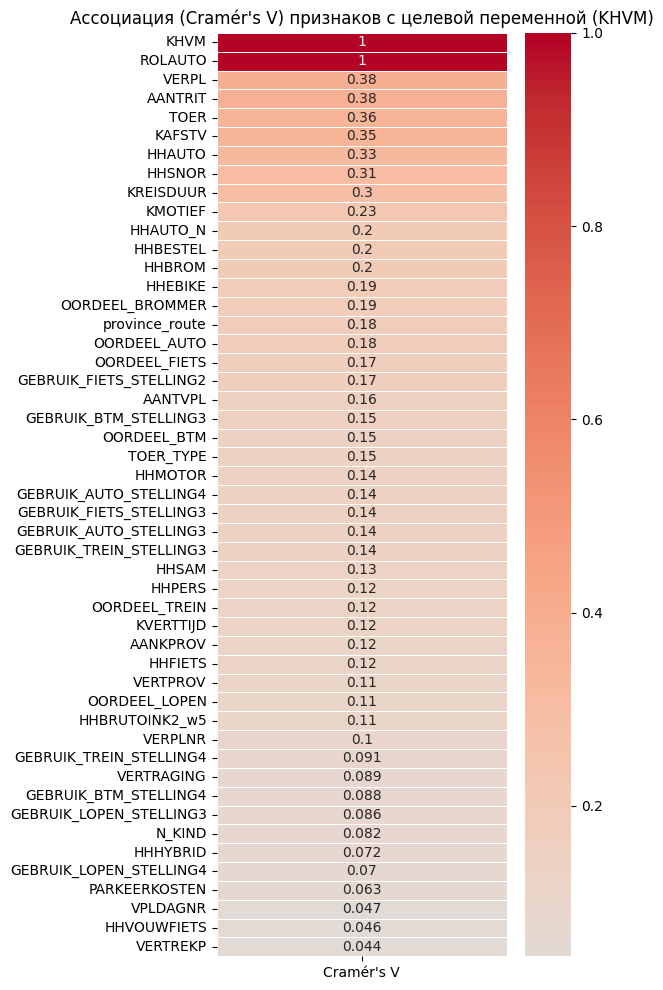

In [12]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))    
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


features = nominal_vars + ordinal_vars
target = 'KHVM'

assoc = {}
for col in features:
    if col in df.columns:
        assoc[col] = cramers_v(df[target], df[col])

assoc_df = pd.DataFrame.from_dict(assoc, orient='index', columns=['Cramér\'s V'])
assoc_df = assoc_df.sort_values(by="Cramér's V", ascending=False)

plt.figure(figsize=(6, 10))
sns.heatmap(assoc_df, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title(f'Ассоциация (Cramér\'s V) признаков с целевой переменной ({target})')
plt.tight_layout()
plt.show()

#### Выводы:
1. `ROLAUTO` - 1.00. Абсолютно предсказуемый признак для типа транспорта — “роль в транспорте” напрямую определяет KHVM.
2. `VERPL` - 0.38. Средняя связь: тип поездки частично объясняет выбор транспорта. Например, для ежедневной поездки люди чаще используют определённые виды транспорта.
3. `AANTRIP` - 0.38. Средняя связь: факт, что в этот день человек не делал поездки, даёт информацию о типе транспорта, хотя и не полностью.
4. `TOER` - 0.36 Средняя связь: пункт отправления/прибытия связан с выбором транспорта (например, короткая поездка пешком, дальняя — на авто).
5. `KAFSTV` - 0.35. Средняя связь: дистанция поездки также влияет на выбор транспорта (короткие поездки чаще пешком/велосипед, длинные — авто, поезд).

## 4. Разбиение на train/test выборки

Для задачи мультиклассовой классфикации таргета `KHVM` выберем стандартное деление 70% для train-выборки и 30% для test-выборки - компромисс между качественным обучением модели и надёжной валидацией её предсказательной способности.

In [13]:
target_name = 'KHVM'
y = df[target_name]
X = df.drop(columns=[target_name])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

ros = RandomOverSampler(random_state=42)
X_train_ros, Y_train_ros = ros.fit_resample(X_train, y_train)

print("Распределение классов после RandomOverSampler:")
print(pd.Series(Y_train_ros).value_counts())

print("Распределение классов в тесте:")
print(pd.Series(y_test).value_counts())


Распределение классов после RandomOverSampler:
KHVM
1    1081
2    1081
3    1081
4    1081
5    1081
6    1081
7    1081
8    1081
Name: count, dtype: int64
Распределение классов в тесте:
KHVM
1    464
6    361
7    262
4    212
3    198
2    108
8     49
5     31
Name: count, dtype: int64


## AutoML (LightAutoML)

Для реализации AutoML-модели я выбрал библиотеку LAMA от братьев наших меньших из сбера.
Далее идет описание AutoML-пайплайна:

In [15]:
train_data = X_train_ros.copy()
train_data[target_name] = Y_train_ros

categorical_columns = list(train_data.select_dtypes(include=['category']).columns)

task = Task('multiclass', metric='crossentropy', greater_is_better=False)

roles = {
    'target': target_name
}

automl = TabularAutoML(
    task=task,
    timeout=1500,
    cpu_limit=1,
    memory_limit=12,
    reader_params={
        'n_jobs': 1,
        'cv': 5
    },
    lgb_params={
        'default_params': {
            'metric': 'multi_logloss',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'n_estimators': 1000
        }
    },
    tuning_params={
        'max_iters': 20,
    }
)

start = time.time()
oof_preds = automl.fit_predict(train_data, roles=roles, verbose=1)
print("⏱ Обучение заняло:", round(time.time() - start, 2), "секунд")

joblib.dump(automl, "automl_khvm_model.joblib")
print("✅ Модель сохранена в 'automl_khvm_model.joblib'")

[01:20:19] Stdout logging level is INFO.
[01:20:19] Task: multiclass

[01:20:19] Start automl preset with listed constraints:
[01:20:19] - time: 1500.00 seconds
[01:20:19] - CPU: 1 cores
[01:20:19] - memory: 12 GB

[01:20:19] Train data shape: (8648, 49)

[01:20:21] Layer 1 train process start. Time left 1498.78 secs
[01:20:21] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[01:20:46] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.0830492180925932
[01:20:46] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[01:20:46] Time left 1473.60 secs

[01:20:50] Selector_LightGBM fitting and predicting completed
[01:20:51] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[01:21:18] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.03299413046361945
[01:21:18] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[01:21:18] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 206.60 secs


Optimization Progress:  27%|██▋       | 27/101 [03:31<09:40,  7.84s/it, best_trial=23, best_value=-0.029]

[01:24:49] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[01:24:49] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[01:25:02] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.02477753827989989
[01:25:02] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[01:25:02] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[01:27:48] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.029700109260969557
[01:27:48] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[01:27:48] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 69.21 secs


/Users/Shared/Py-приколы/Sandbox/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
Optimization Progress:   3%|▎         | 3/101 [01:19<43:27, 26.60s/it, best_trial=1, best_value=-0.0388]

[01:29:07] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[01:29:07] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[01:31:39] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.0316270065821168
[01:31:39] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[01:31:39] Time left 820.71 secs

[01:31:39] Layer 1 training completed.

[01:31:39] Layer 2 train process start. Time left 820.70 secs


/Users/Shared/Py-приколы/Sandbox/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


[01:31:39] Start fitting Lvl_1_Pipe_0_Mod_0_LinearL2 ...
[01:31:48] Fitting Lvl_1_Pipe_0_Mod_0_LinearL2 finished. score = -0.03295267303915912
[01:31:48] Lvl_1_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[01:31:48] Time left 810.86 secs

[01:31:49] Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...
[01:32:16] Fitting Lvl_1_Pipe_1_Mod_0_LightGBM finished. score = -0.03299413046361945
[01:32:16] Lvl_1_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[01:32:16] Time left 783.81 secs

[01:32:16] Layer 2 training completed.

[01:32:16] Blending: optimization starts with equal weights. Score = -0.0312424
[01:32:16] Blending: iteration 0: score = -0.0311997, weights = [0.58743304 0.41256693]
[01:32:16] Blending: no improvements for score. Terminated.

[01:32:16] Blending: best score = -0.0311997, best weights = [0.58743304 0.41256693]
[01:32:16] Automl preset training completed in 716.26 seconds

[01:32:16] Model description:
Models on level 0:
	 5 averaged models Lvl_0_Pipe_0_Mod

Далее тестируем модель и расчитываем метрики


 ОСНОВНЫЕ МЕТРИКИ:
Accuracy:             0.9691
Balanced Accuracy:    0.9405
F1 Macro:             0.9581
F1 Weighted:          0.9691
Log Loss:             0.0927


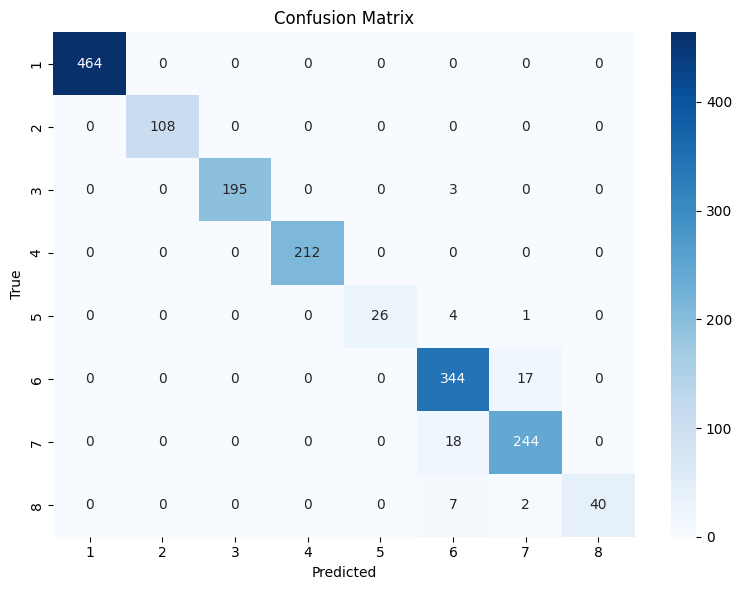


 КЛАССИФИКАЦИОННЫЙ ОТЧЕТ:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       464
           2       1.00      1.00      1.00       108
           3       1.00      0.98      0.99       198
           4       1.00      1.00      1.00       212
           5       1.00      0.84      0.91        31
           6       0.91      0.95      0.93       361
           7       0.92      0.93      0.93       262
           8       1.00      0.82      0.90        49

    accuracy                           0.97      1685
   macro avg       0.98      0.94      0.96      1685
weighted avg       0.97      0.97      0.97      1685



In [19]:
automl = joblib.load("automl_khvm_model.joblib")

X_test_clean = X_test.copy()
test_preds = automl.predict(X_test_clean)


class_labels = np.array(test_preds.features)
y_proba = test_preds.data  # вероятности
y_pred_idx = y_proba.argmax(axis=1)
y_pred = class_labels[y_pred_idx]

y_true = y_test.astype(class_labels.dtype)

print("\n ОСНОВНЫЕ МЕТРИКИ:")
print(f"Accuracy:             {accuracy_score(y_true, y_pred):.4f}")
print(f"Balanced Accuracy:    {balanced_accuracy_score(y_true, y_pred):.4f}")
print(f"F1 Macro:             {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1 Weighted:          {f1_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Log Loss:             {log_loss(y_true, y_proba, labels=class_labels):.4f}")

cm = confusion_matrix(y_true, y_pred, labels=class_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print("\n КЛАССИФИКАЦИОННЫЙ ОТЧЕТ:")
print(classification_report(y_true, y_pred, labels=class_labels))

# Самописная модель

Моя модель будет состоять из Catboost, XGBoost, LightGBM и Random Forest.

Далее идет подготовка данных для обучения моделей классификации с учётом дисбаланса классов и особенностей категориальных признаков.

In [21]:
le_target = LabelEncoder()
y_train_encoded = le_target.fit_transform(Y_train_ros)
y_test_encoded = le_target.transform(y_test)

# Кодирование категориальных признаков для моделей без поддержки категорий
def encode_categorical(train_df, test_df, categorical_cols):
    train_encoded = train_df.copy()
    test_encoded = test_df.copy()
    encoders = {}
    for col in categorical_cols:
        le_col = LabelEncoder()
        all_values = np.unique(
            np.concatenate([train_df[col].astype(str), test_df[col].astype(str)])
        )
        le_col.fit(all_values)
        train_encoded[col] = le_col.transform(train_df[col].astype(str))
        test_encoded[col] = le_col.transform(test_df[col].astype(str))
        encoders[col] = le_col
    return train_encoded, test_encoded, encoders

# Подготовка данных для CatBoost (категории как строки)
def prepare_catboost_data(train_df, test_df, categorical_cols):
    train_cb = train_df.copy()
    test_cb = test_df.copy()
    for col in categorical_cols:
        train_cb[col] = train_cb[col].astype(str)
        test_cb[col] = test_cb[col].astype(str)
    return train_cb, test_cb

# Убираем таргет из списка категориальных колонок
categorical_columns = [c for c in categorical_columns if c != 'KHVM']

# Кодирование таргета
le_target = LabelEncoder()
y_train_encoded = le_target.fit_transform(Y_train_ros)
y_test_encoded = le_target.transform(y_test)

# Кодирование категориальных признаков для моделей без поддержки категорий
X_train_rf, X_test_rf, rf_encoders = encode_categorical(
    X_train_ros,  # только признаки
    X_test,
    categorical_columns
)

# Подготовка данных для CatBoost (категории как строки)
X_train_cat, X_test_cat = prepare_catboost_data(
    X_train_ros, 
    X_test, 
    categorical_columns
)


Обучение базовых моделей классификации и создание мета-признаков для последующего стекинга.

In [ ]:
models = [
    CatBoostClassifier(
        iterations=1000, learning_rate=0.05, depth=6,
        early_stopping_rounds=50, eval_metric='MultiClass',
        loss_function='MultiClass', task_type='CPU',
        cat_features=categorical_columns, verbose=100
    ),
    XGBClassifier(
        n_estimators=1000, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1,
        reg_lambda=1.0, objective='multi:softprob',
        eval_metric='mlogloss', tree_method='hist',
        enable_categorical=True
    ),
    LGBMClassifier(
        n_estimators=1000, learning_rate=0.05, max_depth=-1,
        num_leaves=31, min_child_samples=20, subsample=0.8,
        colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=0.2,
        class_weight='balanced', max_bin=200, device='cpu',
        num_threads=7
    ),
    RandomForestClassifier(
        n_estimators=300, max_depth=15, class_weight='balanced',
        random_state=42, n_jobs=-1
    )
]

model_names = ['CatBoost', 'XGBoost', 'LightGBM', 'RandomForest']
n_classes = len(np.unique(y_train_encoded))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_meta = np.zeros((X_train_cat.shape[0], len(models) * n_classes))
test_meta_folds = np.zeros((X_test_cat.shape[0], len(models) * n_classes, skf.n_splits))

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_cat, y_train_encoded)):
    print(f"\nFold {fold+1}")
    
    X_tr_cat = X_train_cat.iloc[train_idx]
    X_val_cat = X_train_cat.iloc[val_idx]
    
    X_tr_rf = X_train_rf.iloc[train_idx]
    X_val_rf = X_train_rf.iloc[val_idx]
    
    y_tr = y_train_encoded[train_idx]
    y_val = y_train_encoded[val_idx]
    
    for i, model in enumerate(models):
        print(f"  Training model: {model_names[i]}")
        
        if isinstance(model, CatBoostClassifier):
            pool_tr = Pool(X_tr_cat, y_tr, cat_features=categorical_columns)
            pool_val = Pool(X_val_cat, y_val, cat_features=categorical_columns)
            model.fit(pool_tr, eval_set=pool_val)
            train_meta[val_idx, i*n_classes:(i+1)*n_classes] = model.predict_proba(X_val_cat)
            test_meta_folds[:, i*n_classes:(i+1)*n_classes, fold] = model.predict_proba(X_test_cat)
        else:
            model.fit(X_tr_rf, y_tr)
            train_meta[val_idx, i*n_classes:(i+1)*n_classes] = model.predict_proba(X_val_rf)
            test_meta_folds[:, i*n_classes:(i+1)*n_classes, fold] = model.predict_proba(X_test_rf)

test_meta = test_meta_folds.mean(axis=2)

for i, model in enumerate(models):
    joblib.dump(model, f'base_model_{i}.pkl')

np.save('train_meta.npy', train_meta)
np.save('test_meta.npy', test_meta)
np.save("y_train_encoded.npy", y_train_encoded)
np.save("y_test_encoded.npy", y_test_encoded)
print("✅ Модели и мета-признаки сохранены на диск")



Fold 1
  Training model: CatBoost
0:	learn: 1.9256716	test: 1.9276362	best: 1.9276362 (0)	total: 287ms	remaining: 4m 46s
100:	learn: 0.3492489	test: 0.3345918	best: 0.3345918 (100)	total: 37.7s	remaining: 5m 35s
200:	learn: 0.1967726	test: 0.1888375	best: 0.1888375 (200)	total: 1m 17s	remaining: 5m 9s
300:	learn: 0.1568301	test: 0.1543749	best: 0.1543749 (300)	total: 2m 2s	remaining: 4m 45s
400:	learn: 0.1339486	test: 0.1346783	best: 0.1346783 (400)	total: 2m 45s	remaining: 4m 7s
500:	learn: 0.1189618	test: 0.1238844	best: 0.1238844 (500)	total: 3m 25s	remaining: 3m 24s
600:	learn: 0.1073747	test: 0.1142676	best: 0.1142676 (600)	total: 4m 4s	remaining: 2m 42s
700:	learn: 0.0965955	test: 0.1060850	best: 0.1060850 (700)	total: 4m 44s	remaining: 2m 1s
800:	learn: 0.0882418	test: 0.0998825	best: 0.0998825 (800)	total: 5m 24s	remaining: 1m 20s
900:	learn: 0.0803501	test: 0.0940993	best: 0.0940993 (900)	total: 6m 4s	remaining: 40.1s
999:	learn: 0.0741185	test: 0.0894261	best: 0.0894261 (999

### Расчет метрик по фолдам


CatBoost:
  Log Loss      = 0.0910
  Accuracy      = 0.9765
  F1 Macro      = 0.9764
  F1 Weighted   = 0.9764


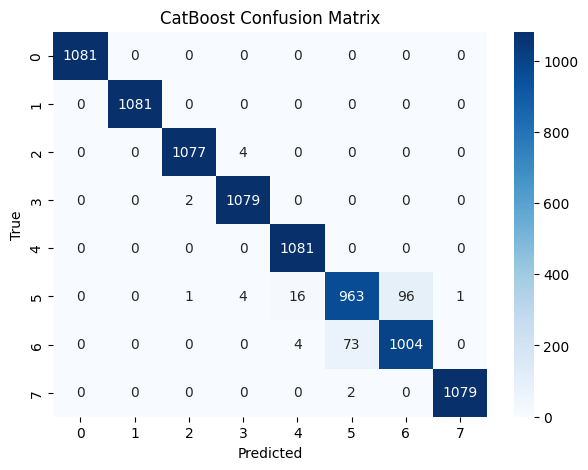


XGBoost:
  Log Loss      = 0.0312
  Accuracy      = 0.9899
  F1 Macro      = 0.9899
  F1 Weighted   = 0.9899


/Users/Shared/Py-приколы/Sandbox/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


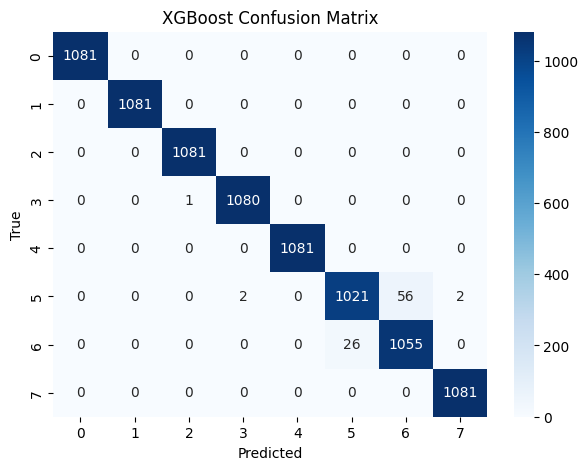


LightGBM:
  Log Loss      = 0.0325
  Accuracy      = 0.9894
  F1 Macro      = 0.9893
  F1 Weighted   = 0.9893


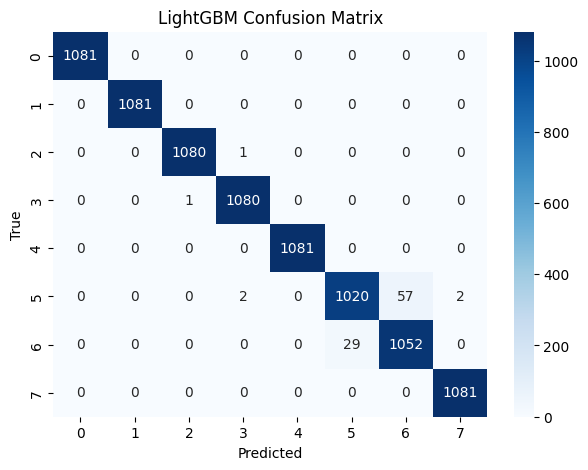


RandomForest:
  Log Loss      = 0.1489
  Accuracy      = 0.9845
  F1 Macro      = 0.9845
  F1 Weighted   = 0.9845


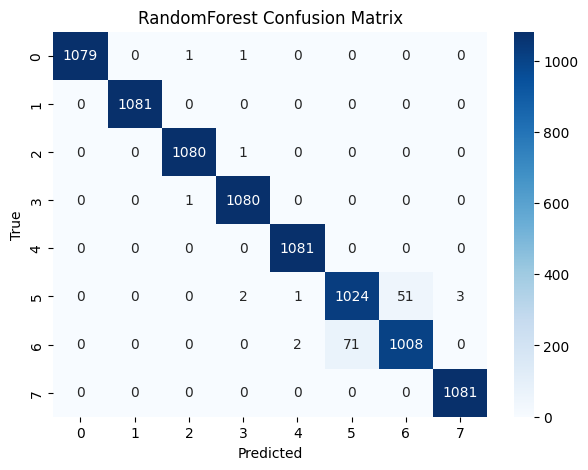

In [35]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, accuracy_score, f1_score, confusion_matrix

train_meta = np.load('train_meta.npy')
y_train_encoded = np.load('y_train_encoded.npy')

model_names = ['CatBoost', 'XGBoost', 'LightGBM', 'RandomForest']
n_classes = train_meta.shape[1] // len(model_names)

for i, model_name in enumerate(model_names):
    y_pred_proba = train_meta[:, i*n_classes:(i+1)*n_classes]
    y_pred_labels = y_pred_proba.argmax(axis=1)

    ll = log_loss(y_train_encoded, y_pred_proba, labels=range(n_classes))
    acc = accuracy_score(y_train_encoded, y_pred_labels)
    f1_macro = f1_score(y_train_encoded, y_pred_labels, average='macro')
    f1_weighted = f1_score(y_train_encoded, y_pred_labels, average='weighted')
    cm = confusion_matrix(y_train_encoded, y_pred_labels, labels=range(n_classes))

    print(f"\n{model_name}:")
    print(f"  Log Loss      = {ll:.4f}")
    print(f"  Accuracy      = {acc:.4f}")
    print(f"  F1 Macro      = {f1_macro:.4f}")
    print(f"  F1 Weighted   = {f1_weighted:.4f}")

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(n_classes), yticklabels=range(n_classes))
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()



### Обучение мета-моделей и сохранение ансамбля

In [31]:
train_meta = np.load("train_meta.npy")
y_train_encoded = np.load("y_train_encoded.npy")

stack_final = CatBoostClassifier(
    iterations=200,
    learning_rate=0.03,
    verbose=0
)

stack_final.fit(train_meta, y_train_encoded)
joblib.dump(stack_final, "stacking_model_final.pkl")


['stacking_model_final.pkl']

### Расчет метрик для итоговой модели

📊 Метрики финальной модели:
Accuracy:               0.9703
Macro Avg F1:           0.9605
Weighted Avg F1:        0.9702
Macro Avg Precision:    0.9804
Weighted Avg Precision: 0.9709
Macro Avg Recall:       0.9441
Weighted Avg Recall:    0.9703
Log Loss:               0.1156


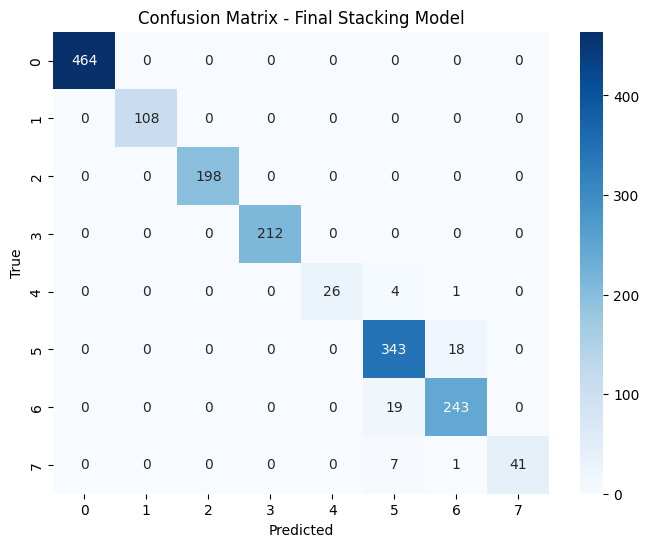

In [44]:
# Загружаем финальный стекинг и мета-признаки
stack_final = joblib.load("stacking_model_final.pkl")
X_test_meta = np.load("test_meta.npy")
y_test_encoded = np.load("y_test_encoded.npy")

# Предсказания
y_test_pred_proba = stack_final.predict_proba(X_test_meta)
y_test_pred = y_test_pred_proba.argmax(axis=1)

# Основные метрики
accuracy = accuracy_score(y_test_encoded, y_test_pred)
macro_f1 = f1_score(y_test_encoded, y_test_pred, average="macro")
weighted_f1 = f1_score(y_test_encoded, y_test_pred, average="weighted")
macro_precision = precision_score(y_test_encoded, y_test_pred, average="macro")
weighted_precision = precision_score(y_test_encoded, y_test_pred, average="weighted")
macro_recall = recall_score(y_test_encoded, y_test_pred, average="macro")
weighted_recall = recall_score(y_test_encoded, y_test_pred, average="weighted")
logloss = log_loss(y_test_encoded, y_test_pred_proba)

print("📊 Метрики финальной модели:")
print(f"Accuracy:               {accuracy:.4f}")
print(f"Macro Avg F1:           {macro_f1:.4f}")
print(f"Weighted Avg F1:        {weighted_f1:.4f}")
print(f"Macro Avg Precision:    {macro_precision:.4f}")
print(f"Weighted Avg Precision: {weighted_precision:.4f}")
print(f"Macro Avg Recall:       {macro_recall:.4f}")
print(f"Weighted Avg Recall:    {weighted_recall:.4f}")
print(f"Log Loss:               {logloss:.4f}")

# Матрица ошибок
cm = confusion_matrix(y_test_encoded, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Final Stacking Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### Глобальная интерпретация с SHAP

ELI5: интерпретируем базовые модели (CatBoost, XGBoost, LightGBM) по исходным признакам.

SHAP: интерпретируем мета-классификатор LightGBM, который принимает предсказания базовых моделей как признаки.

CatBoost Feature Importance:


Weight,Feature
0.2224,ROLAUTO
0.2054,AANTRIT
0.1125,KAFSTV
0.0588,OORDEEL_BROMMER
0.0408,KREISDUUR
0.0320,HHBRUTOINK2_w5
0.0267,KMOTIEF
0.0232,GEBRUIK_TREIN_STELLING3
0.0226,OORDEEL_AUTO
0.0218,GEBRUIK_FIETS_STELLING2


XGBoost Feature Importance:


Weight,Feature
0.3030,ROLAUTO
0.1059,VERPL
0.0797,AANTRIT
0.0580,HHSNOR
0.0438,HHBROM
0.0428,TOER_TYPE
0.0357,TOER
0.0242,AANKPROV
0.0219,PARKEERKOSTEN
0.0200,province_route


LightGBM Feature Importance:


Weight,Feature
0.2952,ROLAUTO
0.1449,AANTRIT
0.1084,KAFSTV
0.0433,OORDEEL_BROMMER
0.0323,HHSNOR
0.0265,GEBRUIK_FIETS_STELLING2
0.0259,HHBROM
0.0227,KREISDUUR
0.0217,TOER_TYPE
0.0185,KMOTIEF


RandomForest Feature Importance:


Weight,Feature
0.1962 ± 0.1151,ROLAUTO
0.0869 ± 0.0730,AANTRIT
0.0799 ± 0.0459,KAFSTV
0.0390 ± 0.0337,KREISDUUR
0.0328 ± 0.0602,VERPL
0.0290 ± 0.0350,HHSNOR
0.0283 ± 0.0244,GEBRUIK_FIETS_STELLING2
0.0279 ± 0.0280,OORDEEL_BROMMER
0.0267 ± 0.0198,KMOTIEF
0.0204 ± 0.0161,AANTVPL


/var/folders/6g/dz7v7l1x2_56ltfk7109p55m0000gn/T/ipykernel_41440/1472408704.py:28: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_meta, X_test_meta_df, plot_type="bar")


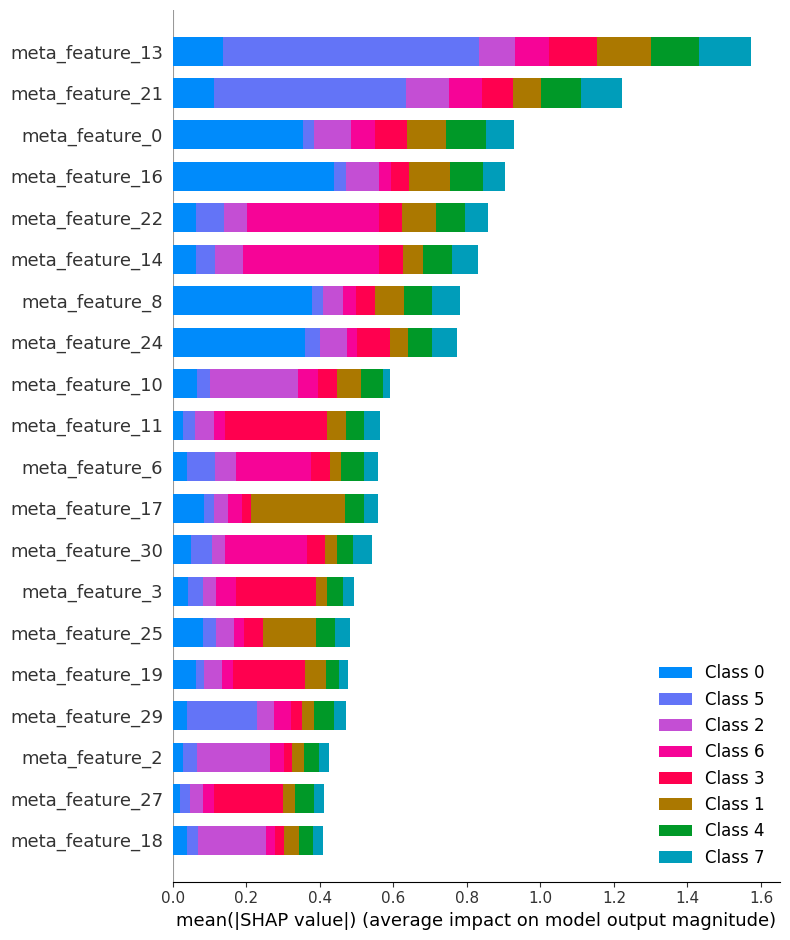

/var/folders/6g/dz7v7l1x2_56ltfk7109p55m0000gn/T/ipykernel_41440/1472408704.py:31: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_meta, X_test_meta_df)


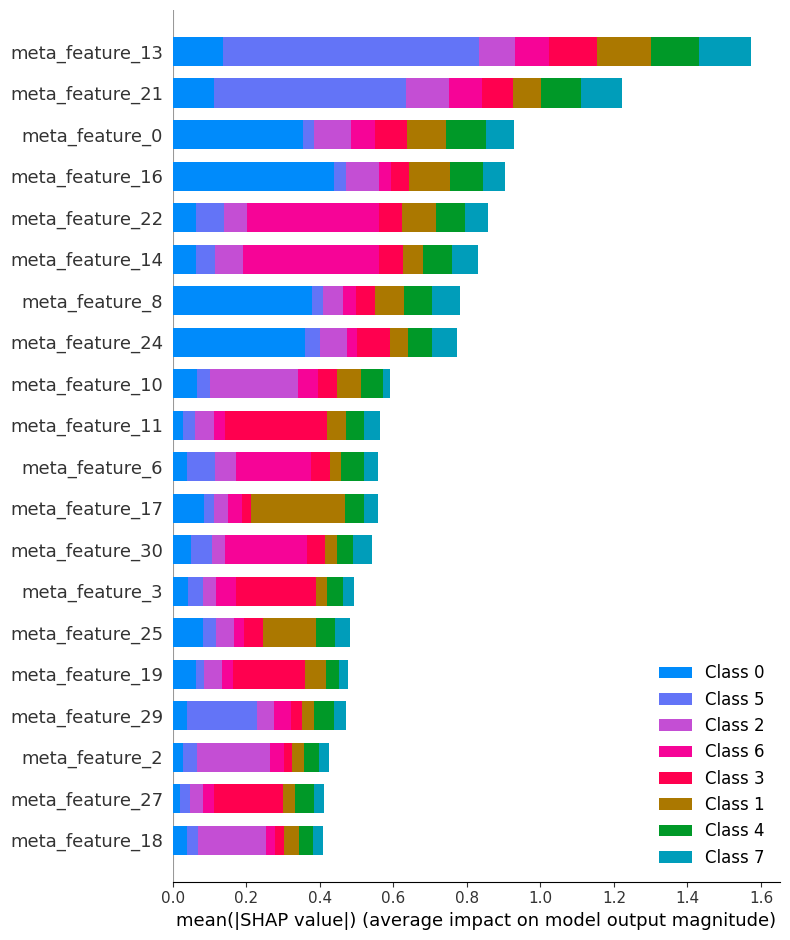

In [46]:
base_models = {
    "CatBoost": joblib.load("base_model_0.pkl"),
    "XGBoost": joblib.load("base_model_1.pkl"),
    "LightGBM": joblib.load("base_model_2.pkl"),
    "RandomForest": joblib.load("base_model_3.pkl")
}

categorical_columns = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

for col in categorical_columns:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

for name, model in base_models.items():
    print(f"{name} Feature Importance:")
    display(eli5.show_weights(model, feature_names=X_train.columns.tolist()))

stack_final = joblib.load("stacking_model_final.pkl")
X_test_meta = np.load("test_meta.npy")
X_test_meta_df = pd.DataFrame(
    X_test_meta, columns=[f"meta_feature_{i}" for i in range(X_test_meta.shape[1])]
)

explainer_meta = shap.Explainer(stack_final)
shap_values_meta = explainer_meta(X_test_meta_df)

plt.title("SHAP Summary Plot for Meta Classifier (CatBoost)")
shap.summary_plot(shap_values_meta, X_test_meta_df, plot_type="bar")

plt.title("SHAP Dot Plot for Meta Classifier (CatBoost)")
shap.summary_plot(shap_values_meta, X_test_meta_df)




=== LIME Explanation for instance position 1436 (True class: 1) ===


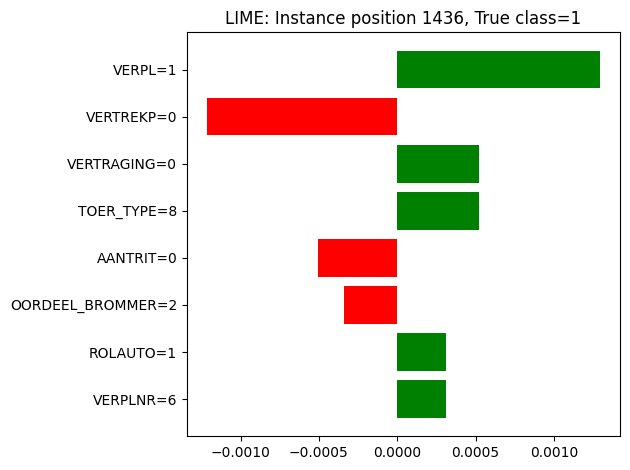



=== LIME Explanation for instance position 1568 (True class: 1) ===


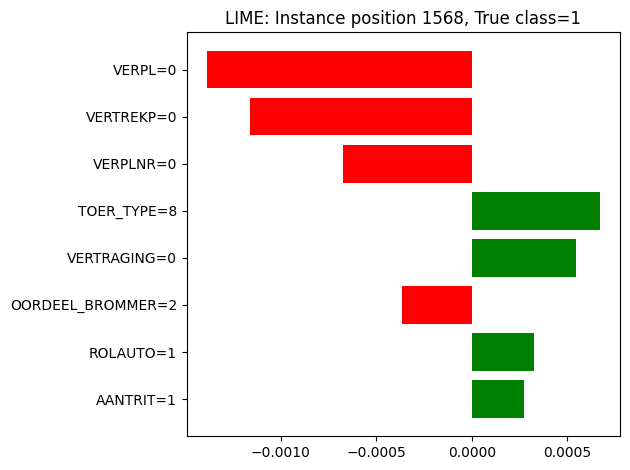



=== LIME Explanation for instance position 381 (True class: 7) ===


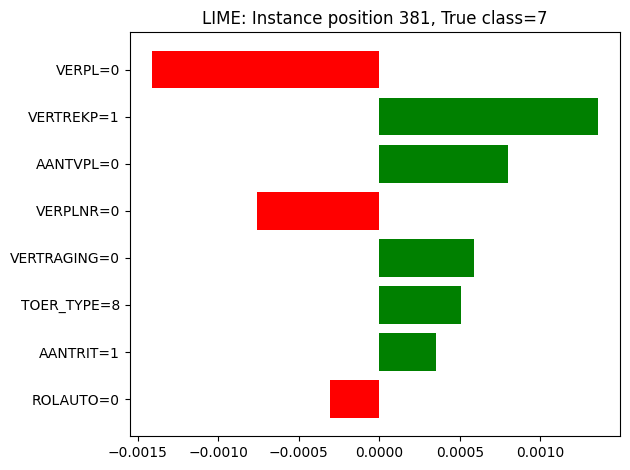

In [ ]:
stack = joblib.load("stacking_model_final.pkl")
y_test_arr = y_test.to_numpy().ravel()

categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features = [X_train.columns.get_loc(col) for col in categorical_columns]

X_train_lime = X_train.copy()
X_test_lime = X_test.copy()
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    combined = pd.concat([X_train_lime[col], X_test_lime[col]], axis=0)
    le.fit(combined)
    X_train_lime[col] = le.transform(X_train_lime[col])
    X_test_lime[col] = le.transform(X_test_lime[col])
    label_encoders[col] = le

X_train_lime = X_train_lime.astype(float)
X_test_lime = X_test_lime.astype(float)

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_lime.values,
    feature_names=X_train_lime.columns.tolist(),
    class_names=[str(c) for c in np.unique(y_test_arr)],
    mode='classification',
    categorical_features=categorical_features,
    discretize_continuous=True,
    random_state=42
)

def custom_predict_proba(X):
    X_df = pd.DataFrame(X, columns=X_train_lime.columns)
    return stack.predict_proba(X_df)

sample_positions = np.random.choice(X_test_lime.shape[0], size=3, replace=False)

for pos in sample_positions:
    x_instance = X_test_lime.iloc[pos].values
    true_class = y_test_arr[pos]

    print(f"\n\n=== LIME Explanation for instance position {pos} (True class: {true_class}) ===")

    exp = explainer_lime.explain_instance(
        data_row=x_instance,
        predict_fn=custom_predict_proba,
        num_features=8,
        num_samples=5000
    )

    fig = exp.as_pyplot_figure()
    plt.title(f"LIME: Instance position {pos}, True class={true_class}")
    plt.tight_layout()
    plt.show()


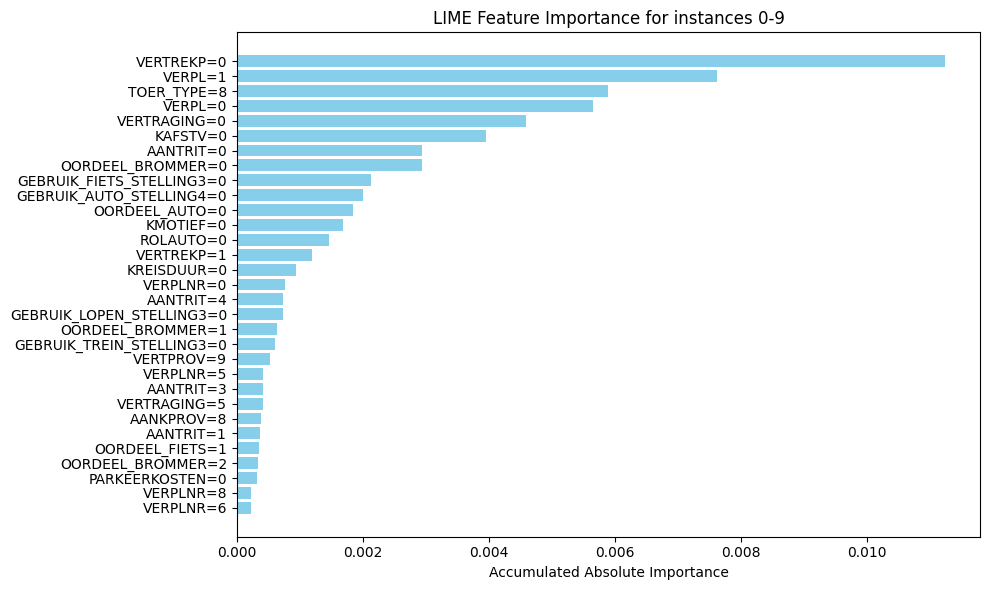

In [56]:
stack = joblib.load("stacking_model_final.pkl")
y_test_arr = y_test.to_numpy().ravel()

categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features = [X_train.columns.get_loc(col) for col in categorical_columns]

X_train_lime = X_train.copy()
X_test_lime = X_test.copy()
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    combined = pd.concat([X_train_lime[col], X_test_lime[col]], axis=0)
    le.fit(combined)
    X_train_lime[col] = le.transform(X_train_lime[col])
    X_test_lime[col] = le.transform(X_test_lime[col])
    label_encoders[col] = le

X_train_lime = X_train_lime.astype(float)
X_test_lime = X_test_lime.astype(float)

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_lime.values,
    feature_names=X_train_lime.columns.tolist(),
    class_names=[str(c) for c in np.unique(y_test_arr)],
    mode='classification',
    categorical_features=categorical_features,
    discretize_continuous=True,
    random_state=42
)

def custom_predict_proba(X):
    X_df = pd.DataFrame(X, columns=X_train_lime.columns)
    return stack.predict_proba(X_df)

# Диапазон индексов для анализа, например 10 последовательных экземпляров
start_idx, end_idx = 0, 10
indices_range = range(start_idx, min(end_idx, X_test_lime.shape[0]))

feature_importance_sum = collections.Counter()

for idx in indices_range:
    x_instance = X_test_lime.iloc[idx].values
    true_class = y_test_arr[idx]

    exp = explainer_lime.explain_instance(
        data_row=x_instance,
        predict_fn=custom_predict_proba,
        num_features=8,
        num_samples=5000
    )

    for feat, weight in exp.as_list():
        feature_importance_sum[feat] += abs(weight)

# Сортировка признаков по суммарной важности
sorted_features = feature_importance_sum.most_common()

features, importances = zip(*sorted_features)
plt.figure(figsize=(10, 6))
plt.barh(features[::-1], importances[::-1], color='skyblue')
plt.xlabel("Accumulated Absolute Importance")
plt.title(f"LIME Feature Importance for instances {start_idx}-{end_idx-1}")
plt.tight_layout()
plt.show()
